In [1]:
# General libraries
from os import path, listdir
from sys import path as sysPath

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For data preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For data analysis
from sklearn.metrics import confusion_matrix, accuracy_score

# For loading in Matt's python libraries for SPAM related content
sysPath.append( path.abspath( "../Support_Code/" ) )
import general_module as gm
import info_module as im
gm.test()
im.test()


GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM


In [2]:
tInfo = im.target_info_class( targetDir = '../../spam_data_pl3/587722984435351614/', printAll = False, newInfo=False)
print(tInfo.status)

True


In [ ]:
# Read data 
wndDir = tInfo.targetDir + 'wndcharm/'
f1Loc = wndDir + 'f1_feats.csv'
f1DF = pd.read_csv(f1Loc,)
print(f1DF.shape)
print(f1DF)

(1, 5102, 1750) (5102,)
(1, 4870, 1750) (4870,)



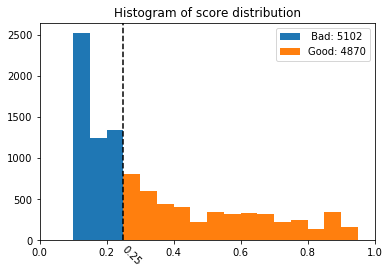

In [12]:
X = f1DF.iloc[:,2:].values 
y = f1DF.iloc[:,1].values

badId = np.where( y < 0.25 )
goodId = np.where( y >= 0.25 )
badX = X[badId,:]
badY = y[badId]
goodX = X[goodId,:]
goodY = y[goodId]
print(badX.shape, badY.shape)
print(goodX.shape, goodY.shape)
print("")

plt.hist( badY, bins=20, range=(0,1), label=' Bad: %d'%badY.shape[0] )
plt.hist(goodY, bins=20, range=(0,1), label='Good: %d'%goodY.shape[0] )
plt.axvline(0.25, c='k', ls='--', )
plt.text(0.24,-300,'0.25', rotation=-45)
plt.title("Histogram of score distribution")
plt.legend()
plt.xlim([0,1])
plt.show()

In [75]:
# Create discrete labels for those above and below 0.25
yd1 = np.zeros(y.shape[0])
yd1[y>0.25] = 1
yd1 = yd1.astype(int)

print('Discrete label')
# sample y values for confirmation
for i in range(0,9900,1000):
    print('%.2f -> %d ' % ( y[i], yd1[i] ) )

print()

Discrete label
0.95 -> 1 
0.71 -> 1 
0.56 -> 1 
0.40 -> 1 
0.31 -> 1 
0.24 -> 0 
0.20 -> 0 
0.17 -> 0 
0.15 -> 0 
0.14 -> 0 



In [16]:
# For retrieving basic statistics on predicted vs actual
def get_stats( y, y_pred ):
    # print results
    cm = confusion_matrix( y, y_pred )
    acc =  accuracy_score( y, y_pred )
    
    return cm, acc

class dec_tree_class:
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree
    
    # Variables 
    k_fold = 10
    name = 'decision_tree'
    classifier = None
    depth = 4   
    
    def __init__( self, X_train, y_train, criterion = 'entropy' ):

        # Training data
        self.criterion = criterion
        self.classifier = self.DecisionTreeClassifier(max_depth=2, criterion = self.criterion, random_state = 0 )
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
        
    def plotTree( self, X_train, y_train, depth = 2 ):

        # Training data
        self.classifier = self.DecisionTreeClassifier(max_depth=self.depth, criterion = self.criterion, random_state = 0 )
        self.classifier = self.classifier.fit(X_train, y_train)
        self.tree.plot_tree( self.classifier )
    
    def cv_accuracy( self, X, y, k_fold = 5, depth=3 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        for i, indexes in enumerate( kf.split( X ) ):
            
            print("Cross Validate: %d"%i,end='\r')
            
            train_i, test_i = indexes
            
            tx_train, tx_test = X[train_i], X[test_i]
            ty_train, ty_test = y[train_i], y[test_i]   
            
            temp_class = self.DecisionTreeClassifier( max_depth=depth, criterion = self.criterion, random_state = 0 )
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
            
        return np.mean( scores )
        
dt_classifier = dec_tree_class( X, yd1, )  
print(dt_classifier.name) 
print(dt_classifier.cv_accuracy(X,yd1))
#dt_classifier.plotTree(X,y1)

scores = []

for i in range(1,10):
    print(i)
    scores.append( dt_classifier.cv_accuracy(X,yd1, depth=i) )
print("Tree created")

decision_tree
0.7672251843249046


Text(0.5, 0, 'Tree Depth')

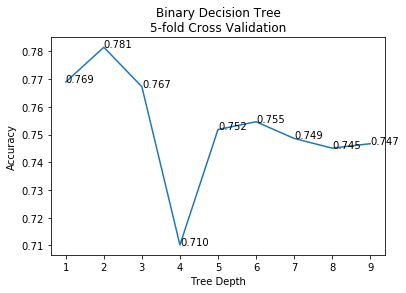

In [17]:
plt.plot(range(1,10),scores)
for i,s in enumerate(scores):    
    plt.text( i+1, s, '%.3f'%s, rotation=0)

plt.title("Binary Decision Tree\n5-fold Cross Validation")
plt.ylabel("Accuracy")
plt.xlabel("Tree Depth")

In [23]:
class k_neighbor_class:
    
    from sklearn.neighbors import KNeighborsClassifier
    
    # Variables 
    name = "K_Nearest_Neighbor"
    
    
    def __init__( self, X_train, y_train, n_neighbors = 15 ):
        
        self.n_neighbors = n_neighbors
        self.classifier = self.KNeighborsClassifier(n_neighbors = n_neighbors, metric = 'minkowski', p = 2, )
        self.classifier = self.classifier.fit(X_train, y_train)
    
    def predict( self, X_test ):        
        return self.classifier.predict( X_test )
    
    def cv_accuracy( self, X_train, y_train, k_fold = 10 ):
        
        from sklearn.model_selection import KFold
        kf = KFold( n_splits= k_fold )
        
        scores = np.zeros(k_fold)
        
        for i, indexes in enumerate( kf.split( X_train ) ):
            
            print('%d / %d' % (i, k_fold), end='\r' )
            train_i, test_i = indexes
            
            tx_train, tx_test = X_train[train_i], X_train[test_i]
            ty_train, ty_test = y_train[train_i], y_train[test_i]   
            
            temp_class = self.KNeighborsClassifier( n_neighbors = self.n_neighbors, p = 2, )
            temp_class = temp_class.fit( tx_train, ty_train )            
            ty_pred = temp_class.predict( tx_test )
            
            t_cm, t_acc = get_stats( ty_test, ty_pred )
            
            scores[i] = t_acc
            
        return np.mean( scores )

# prep plot
nmin = 5
nmax = 11
nstep = int( (nmax-nmin) / 2 + 1)

x_plot = np.linspace( nmin, nmax, nstep)
y_plot = np.zeros( len(x_plot) )

# fill plot
for i, x in enumerate(x_plot):  
    print('%d / %d' % (i,nstep) )
    kn_classifier = k_neighbor_class( X, yd1, n_neighbors = int(x) )
    fold_scores = kn_classifier.cv_accuracy( X, yd1, k_fold=5 )
    y_plot[i] = fold_scores
    

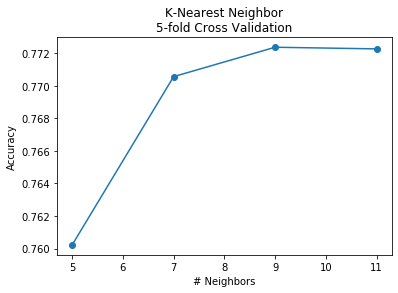

In [60]:
plt.plot(x_plot,y_plot,'o-')
plt.title('K-Nearest Neighbor\n5-fold Cross Validation')
plt.ylabel('Accuracy')
plt.xlabel('# Neighbors')
plt.show()


In [32]:
# Create black-box Artificial Nueral Network
import tensorflow as tf

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [72]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=20, input_dim=X.shape[1], activation='relu'))
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile( optimizer = 'adam', loss = 'mse', metrics = ['mean_absolute_error'] )
ann.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                35020     
_________________________________________________________________
dense_33 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_34 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 21        
Total params: 35,881
Trainable params: 35,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2)

(1995,)
(1995, 1)
0.9727488511773315


Text(0.5, 1.0, 'WNDCHARM: Dense Neural Network\n Correlation: 0.97')

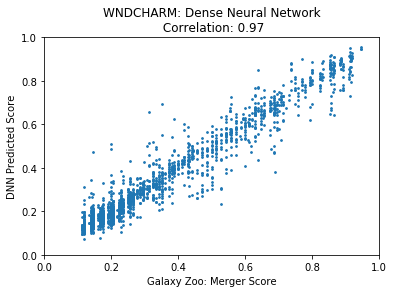

In [82]:
y_pred = ann.predict(X_test)
plt.scatter(y_test,y_pred,s=3)
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Galaxy Zoo: Merger Score')
plt.ylabel('DNN Predicted Score')

title = 'Dense Neural Network'
print(y_test.shape)
print(y_pred.shape)
corr = np.corrcoef(y_test, y_pred[:,0])[0,1]
print(corr)

plt.title('WNDCHARM: Dense Neural Network\n Correlation: %.2f'%corr)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


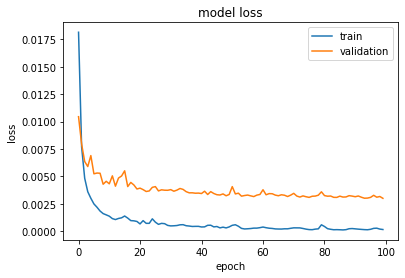

In [71]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()